# APLICACIÓN DEL MODELO DE MACHINE LEARNING

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CARGAR Y PREPROCESAR DATOS

In [ ]:
# Cargar datos
df = pd.read_csv('./soja-serie-1941-2023.csv', encoding='utf-8')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

# Convertir a tipos numéricos
cols_num = ['anio','provincia_id','departamento_id','superficie_sembrada_ha',
            'superficie_cosechada_ha','produccion_tm','rendimiento_kgxha']

for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors='coerce')

#  MANEJO DE OUTLIERS EN RENDIMIENTO

Dataset original: 12315 filas
Dataset sin outliers: 12253 filas
Outliers eliminados: 62 filas


C:\Users\briia\AppData\Local\Temp\ipykernel_17712\1765538892.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='Estado', y='rendimiento_kgxha', palette='viridis')


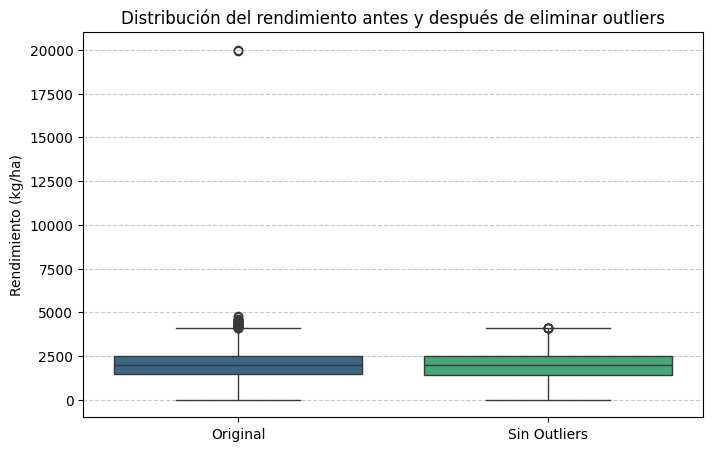

In [15]:
Q1 = df['rendimiento_kgxha'].quantile(0.25)
Q3 = df['rendimiento_kgxha'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

df_sin_outliers = df[(df['rendimiento_kgxha'] >= limite_inf) & 
                     (df['rendimiento_kgxha'] <= limite_sup)]

print(f"Dataset original: {len(df)} filas")
print(f"Dataset sin outliers: {len(df_sin_outliers)} filas")
print(f"Outliers eliminados: {len(df) - len(df_sin_outliers)} filas")

df_box = pd.DataFrame({
    'rendimiento_kgxha': pd.concat([
        df['rendimiento_kgxha'], 
        df_sin_outliers['rendimiento_kgxha']
    ], ignore_index=True),
    'Estado': ['Original'] * len(df) + ['Sin Outliers'] * len(df_sin_outliers)
})

# --- Gráfico de caja ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_box, x='Estado', y='rendimiento_kgxha', palette='viridis')
plt.title('Distribución del rendimiento antes y después de eliminar outliers')
plt.xlabel('')
plt.ylabel('Rendimiento (kg/ha)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()